In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import skfuzzy as fuzz
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

# sklearn.set_config(transform_output="pandas")
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
flight_data_train = pd.read_csv('./flight_data_train_ts.csv')
flight_data_test = pd.read_csv('./flight_data_test_ts.csv')

In [3]:
flight_data_train['scheduledoffblocktime'] = pd.to_datetime(flight_data_train['scheduledoffblocktime'])
flight_data_test['scheduledoffblocktime'] = pd.to_datetime(flight_data_test['scheduledoffblocktime'])

# flight_data_train.sort_values(by='scheduledoffblocktime', inplace=True)
# flight_data_test.sort_values(by='scheduledoffblocktime', inplace=True)

Feature Selection

In [4]:
def chi_2(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])

    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-Square Statistic for {x} and {y}: {chi2}, p-value: {p}, dof:{dof}")

In [5]:
def cramers_v(df, x, y):
    # Create a contingency table
    contingency_table = pd.crosstab(df[x], df[y])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cor = np.sqrt(chi2 / (n * min_dim))
    print(f"Cramer's V  for {x} and {y}: {cor}, p-value: {p}")

In [6]:
flight_data_train.columns

Index(['scheduledoffblocktime', 'traffictypecode', 'airlinecode_iata',
       'destination_iata', 'aircraft_iata', 'isconnecting', 'publicgatenumber',
       'aircraftterminal', 'tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti',
       'vsby', 'gust', 'skyc1', 'skyc2', 'skyl1', 'skyl2', 'finalflightstatus',
       'delay_in_secs'],
      dtype='object')

In [7]:
chi_2(flight_data_train, 'publicgatenumber', 'finalflightstatus')
cramers_v(flight_data_train, 'publicgatenumber', 'finalflightstatus')

Chi-Square Statistic for publicgatenumber and finalflightstatus: 3653.5185592382445, p-value: 0.0, dof:138
Cramer's V  for publicgatenumber and finalflightstatus: 0.14586302601258685, p-value: 0.0


In [8]:
chi_2(flight_data_train, 'destination_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'destination_iata', 'finalflightstatus')

Chi-Square Statistic for destination_iata and finalflightstatus: 8301.845466494837, p-value: 0.0, dof:311
Cramer's V  for destination_iata and finalflightstatus: 0.21987552153760798, p-value: 0.0


In [9]:
chi_2(flight_data_train, 'aircraft_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'aircraft_iata', 'finalflightstatus')

Chi-Square Statistic for aircraft_iata and finalflightstatus: 3711.169825246382, p-value: 0.0, dof:60
Cramer's V  for aircraft_iata and finalflightstatus: 0.14700935572653068, p-value: 0.0


In [10]:
chi_2(flight_data_train, 'airlinecode_iata', 'finalflightstatus')
cramers_v(flight_data_train, 'airlinecode_iata', 'finalflightstatus')

Chi-Square Statistic for airlinecode_iata and finalflightstatus: 9039.246389847638, p-value: 0.0, dof:149
Cramer's V  for airlinecode_iata and finalflightstatus: 0.22943288824568359, p-value: 0.0


In [11]:
# columns_to_drop = ['publicgatenumber']

# flight_data_train.drop(columns=columns_to_drop, axis=1, inplace=True)
# flight_data_test.drop(columns=columns_to_drop, axis=1, inplace=True)

In [12]:
departdatetime = flight_data_train['scheduledoffblocktime'].dt

flight_data_train['depart_day'] = departdatetime.day
flight_data_train['depart_month'] = departdatetime.month
flight_data_train['depart_dayofweek'] = departdatetime.dayofweek
flight_data_train['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute
# Test
departdatetime = flight_data_test['scheduledoffblocktime'].dt
flight_data_test['depart_day'] = departdatetime.day
flight_data_test['depart_month'] = departdatetime.month
flight_data_test['depart_dayofweek'] = departdatetime.dayofweek
flight_data_test['depart_minute'] = departdatetime.hour * 60 + departdatetime.minute

flight_data_train.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)
flight_data_test.drop(columns=['scheduledoffblocktime'], axis=1, inplace=True)

In [13]:
X_train = flight_data_train.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)
X_test = flight_data_test.drop(columns=['delay_in_secs', 'finalflightstatus'], axis=1)

y_train = flight_data_train['finalflightstatus']
y_test = flight_data_test['finalflightstatus']

In [14]:
y_train = y_train.map({'On-Time': 0, 'Delayed':1})
y_test = y_test.map({'On-Time': 0, 'Delayed':1})

In [15]:
X_train

,traffictypecode,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,aircraftterminal,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyc1,skyc2,skyl1,skyl2,depart_day,depart_month,depart_dayofweek,depart_minute
0,PS,RA,KTM,332,0,F8,2,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
1,PS,ET,ADD,77W,0,D6,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,265
2,PS,6E,BOM,320,0,D7,1,69.8,62.6,77.90,90.0,5.0,29.88,6.21,0,CAVOK,CAVOK,0.0,0.0,8,3,6,270
3,PS,EK,MLE,77W,0,C14,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
4,PS,EK,CGK,77W,0,A8,3,68.0,60.8,77.75,110.0,6.0,29.88,5.59,0,NSC,CAVOK,0.0,0.0,8,3,6,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171715,PS,EK,BRU,77W,0,B29,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171716,PS,EK,IST,77W,0,B10,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171717,PS,EK,DUS,388,0,B17,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,860
171718,PS,EK,LIS,77W,0,B22,3,95.0,66.2,39.00,350.0,12.0,29.71,4.35,0,NSC,CAVOK,0.0,0.0,6,5,4,865


In [16]:
# from imblearn.over_sampling import SMOTENC

# smote = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3, 5, 16, 17])
# print('Original dataset shape %s' % Counter(y_train_cls))
# X_train, y_train_cls = smote.fit_resample(X_train, y_train_cls)
# print('Resampled dataset shape %s' % Counter(y_train_cls))


In [17]:
import pandas as pd
from category_encoders import CatBoostEncoder

high_cardinality_cols = ['airlinecode_iata', 'destination_iata', 'aircraft_iata', 'publicgatenumber']

catboost_encoder = CatBoostEncoder(cols=high_cardinality_cols, return_df=True)

X_train_encoded = catboost_encoder.fit_transform(X_train, y_train)

X_test_encoded = catboost_encoder.transform(X_test)

X_train = X_train_encoded
X_test = X_test_encoded

In [18]:
# one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', 'airlinecode_iata', 'destination_iata']
one_hot_column =  ['skyc1', 'skyc2', 'traffictypecode', 'aircraftterminal', ]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

encoded = ohe.fit_transform(X_train[one_hot_column])
ohe_new_columns = ohe.get_feature_names_out(one_hot_column)
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_train = pd.concat([X_train.drop(columns=one_hot_column), encoded_df], axis=1)

encoded = ohe.transform(X_test[one_hot_column])
encoded_df = pd.DataFrame(encoded, columns=ohe_new_columns)
X_test = pd.concat([X_test.drop(columns=one_hot_column), encoded_df], axis=1)



In [19]:
numerical_cols = ['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'skyl1', 'skyl2']

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [21]:
# Create cyclic features for month and day
X_train['depart_month_sin'] = np.sin(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_month_cos'] = np.cos(2 * np.pi * X_train['depart_month'] / 12)
X_train['depart_day_sin'] = np.sin(2 * np.pi * X_train['depart_day'] / 31) 
X_train['depart_day_cos'] = np.cos(2 * np.pi * X_train['depart_day'] / 31)
X_train['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_train['depart_dayofweek'] / 7) 
X_train['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_train['depart_dayofweek'] / 7)
X_train['depart_minute_sin'] = np.sin(2 * np.pi * X_train['depart_minute'] / 1440) 
X_train['depart_minute_cos'] = np.cos(2 * np.pi * X_train['depart_minute'] / 1440)

X_test['depart_month_sin'] = np.sin(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_month_cos'] = np.cos(2 * np.pi * X_test['depart_month'] / 12)
X_test['depart_day_sin'] = np.sin(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_day_cos'] = np.cos(2 * np.pi * X_test['depart_day'] / 31)
X_test['depart_dayofweek_sin'] = np.sin(2 * np.pi * X_test['depart_dayofweek'] / 7) 
X_test['depart_dayofweek_cos'] = np.cos(2 * np.pi * X_test['depart_dayofweek'] / 7)
X_test['depart_minute_sin'] = np.sin(2 * np.pi * X_test['depart_minute'] / 1440)
X_test['depart_minute_cos'] = np.cos(2 * np.pi * X_test['depart_minute'] / 1440)

# Drop original features
X_train = X_train.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)
X_test = X_test.drop(['depart_month', 'depart_day', 'depart_minute', 'depart_dayofweek'], axis=1)


In [22]:
X_train

,airlinecode_iata,destination_iata,aircraft_iata,isconnecting,publicgatenumber,tmpf,dwpf,relh,drct,sknt,alti,vsby,gust,skyl1,skyl2,skyc1_CAVOK,skyc1_FEW,skyc1_NSC,skyc1_OVC,skyc1_SCT,skyc1_VV,skyc2_CAVOK,skyc2_FEW,skyc2_NSC,skyc2_SCT,traffictypecode_PE,traffictypecode_PS,aircraftterminal_1,aircraftterminal_2,aircraftterminal_3,depart_month_sin,depart_month_cos,depart_day_sin,depart_day_cos,depart_dayofweek_sin,depart_dayofweek_cos,depart_minute_sin,depart_minute_cos
0,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.915311,0.402747
1,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.915311,0.402747
2,0.274493,0.274493,0.274493,0,0.274493,0.242424,0.650,0.767540,0.250000,0.185185,0.652632,1.000000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.923880,0.382683
3,0.274493,0.274493,0.137247,0,0.274493,0.212121,0.625,0.765962,0.305556,0.222222,0.652632,0.899676,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.932008,0.362438
4,0.137247,0.274493,0.091498,0,0.274493,0.212121,0.625,0.765962,0.305556,0.222222,0.652632,0.899676,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.123234e-17,0.998717,-0.050649,-0.781831,0.623490,0.932008,0.362438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171715,0.224980,0.155440,0.208386,0,0.225553,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171716,0.224991,0.239724,0.208400,0,0.175686,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171717,0.224988,0.194093,0.343861,0,0.262227,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.573576,-0.819152
171718,0.224985,0.285690,0.208397,0,0.187338,0.666667,0.700,0.358368,0.972222,0.444444,0.473684,0.699029,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.5,-8.660254e-01,0.937752,0.347305,-0.433884,-0.900969,-0.591310,-0.806445


In [24]:
from sklearn.cluster import KMeans
#Creating models for k from 2 to 14
inertia = []
for k in range(2,31):
    model = KMeans(n_clusters=k, random_state=42).fit(X_train)
    inertia.append(model.inertia_)

#Plotting the inertia of the models    
k_values = range(2,31)
plt.plot(k_values, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [159]:
# sc = DBSCAN(eps=1.4, min_samples=37*2, algorithm='kd_tree')
# clusters = pd.DataFrame(sc.fit_predict(X_train), columns=['Cluster'])
# clusters['Cluster'].value_counts()

In [160]:
param_space = {
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'criterion': Categorical(['gini', 'entropy', 'log_loss'])
}

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


# Use Bayesian optimization for hyperparameter tuning
rf = RandomForestClassifier(
    criterion='gini',
    max_depth=50,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    max_features='sqrt'
)
rf.fit(X_train_balanced, y_train_balanced)
# Make predictions and evaluate metrics
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(classification_report(y_test, y_pred))


Original class distribution:
finalflightstatus
0    124584
1     47136
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    124584
1    124584
Name: count, dtype: int64
Accuracy: 0.6252292856768513
Precision: 0.31102026911940045
Recall: 0.370235198702352
F1 Score: 0.3380542441914283
              precision    recall  f1-score   support

           0       0.76      0.71      0.74     14149
           1       0.31      0.37      0.34      4932

    accuracy                           0.63     19081
   macro avg       0.54      0.54      0.54     19081
weighted avg       0.65      0.63      0.64     19081



In [178]:
hdbscan_model = HDBSCAN(
    min_cluster_size=3000,      # Increase to avoid microclusters
    min_samples=5,              # Lower to reduce noise points
    cluster_selection_epsilon=0.5,  # Increase to reduce noise points
    cluster_selection_method='eom',  # 'eom' tends to produce more balanced clusters
    prediction_data=True,
    core_dist_n_jobs=-1
)
clusters_train = pd.DataFrame(hdbscan_model.fit_predict(X_train), columns=['Cluster'])
clusters_train['Cluster'].value_counts()

Cluster
 9    65112
 7    26393
 8    21306
 4    16190
-1    12950
 5     7957
 3     5910
 1     4793
 2     4486
 6     3515
 0     3108
Name: count, dtype: int64

In [179]:
from hdbscan import approximate_predict
clusters_test, _ = approximate_predict(hdbscan_model, X_test)
pd.Series(clusters_test).value_counts()


-1    6402
 9    6066
 8    2232
 4    1925
 7    1388
 1     612
 0     242
 2     181
 3      32
 6       1
Name: count, dtype: int64

In [180]:
X_train['cluster'] = clusters_train['Cluster']
X_test['cluster'] = clusters_test


In [194]:
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical

rf_models = {}
metrics = {}
model_weights_f1 = {}
model_weights_cluster = {}

for cluster in np.unique(clusters_train):
    if cluster == -1:  # Ignore noise points (label -1)
        continue
    
    print(f'Cluster {cluster}')

    # Subset the training and test data for the cluster
    # Get cluster data
    X_cluster = X_train[X_train['cluster'] == cluster].drop(columns=['cluster'])
    y_cluster = y_train.loc[X_cluster.index]
    
    # Split into train and validation sets
    X_train_cluster, X_val_cluster, y_train_cluster, y_val_cluster = train_test_split(
        X_cluster, y_cluster, test_size=0.2, random_state=42
    )
    
    X_test_cluster = X_test[X_test['cluster'] == cluster].drop(columns=['cluster'])
    y_test_cluster = y_test.loc[X_test_cluster.index]
    
    # Apply SMOTE to balance the training data
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_cluster, y_train_cluster)

# Print class distribution before and after SMOTE
    print("Original class distribution:")
    print(pd.Series(y_train_cluster).value_counts())
    print("\nBalanced class distribution:")
    print(pd.Series(y_train_balanced).value_counts())

    # Define objective function for hyperopt
    param_space = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 5),
        'max_features': Categorical(['sqrt', 'log2']),
        'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    }

    # Use Bayesian optimization for hyperparameter tuning
    bayes_cv = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=param_space,
        n_iter=50,
        cv=3,
        n_jobs=-1,
        scoring='f1'
    )
    bayes_cv.fit(X_train_balanced, y_train_balanced)
    best_rf = bayes_cv.best_estimator_
    rf_models[cluster] = best_rf
    
    # Cluster weighted
    cluster_weight = len(y_cluster) / len(y_train)
    model_weights_cluster[cluster] = cluster_weight

    # Make predictions on the validation set and evaluate metrics
    y_val_pred = best_rf.predict(X_val_cluster)
    accuracy = accuracy_score(y_val_cluster, y_val_pred)
    precision = precision_score(y_val_cluster, y_val_pred)
    recall = recall_score(y_val_cluster, y_val_pred)
    f1 = f1_score(y_val_cluster, y_val_pred)
    model_weights_f1[cluster] = 1 / f1 if f1 != 0 else 1  # Assign weight to the model based on validation MSE

    # Print metrics
    print(f"Cluster {cluster} Validation Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("==========================================")
    print()

Cluster 0
Original class distribution:
finalflightstatus
0    1785
1     701
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
1    1785
0    1785
Name: count, dtype: int64


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 0 Validation Metrics:
Accuracy: 0.7282958199356914
Precision: 0.5225806451612903
Recall: 0.4602272727272727
F1 Score: 0.48942598187311176

Cluster 1
Original class distribution:
finalflightstatus
0    2787
1    1047
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    2787
1    2787
Name: count, dtype: int64
Cluster 1 Validation Metrics:
Accuracy: 0.7299270072992701
Precision: 0.4951923076923077
Recall: 0.40077821011673154
F1 Score: 0.443010752688172

Cluster 2
Original class distribution:
finalflightstatus
0    2492
1    1096
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    2492
1    2492
Name: count, dtype: int64
Cluster 2 Validation Metrics:
Accuracy: 0.6703786191536748
Precision: 0.498220640569395
Recall: 0.4745762711864407
F1 Score: 0.4861111111111111

Cluster 3
Original class distribution:
finalflightstatus
0    3257
1    1471
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    3257
1    32

/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 3 Validation Metrics:
Accuracy: 0.6802030456852792
Precision: 0.5124555160142349
Recall: 0.37402597402597404
F1 Score: 0.43243243243243246

Cluster 4
Original class distribution:
finalflightstatus
0    9815
1    3137
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
1    9815
0    9815
Name: count, dtype: int64


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 4 Validation Metrics:
Accuracy: 0.7415071031500926
Precision: 0.44869565217391305
Recall: 0.33161953727506427
F1 Score: 0.38137472283813745

Cluster 5
Original class distribution:
finalflightstatus
0    4716
1    1649
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    4716
1    4716
Name: count, dtype: int64


/home/abdussaboor/.virtualenvs/mlr570-project/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cluster 5 Validation Metrics:
Accuracy: 0.7085427135678392
Precision: 0.42032967032967034
Recall: 0.3768472906403941
F1 Score: 0.3974025974025974

Cluster 6
Original class distribution:
finalflightstatus
0    1759
1    1053
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
0    1759
1    1759
Name: count, dtype: int64
Cluster 6 Validation Metrics:
Accuracy: 0.6742532005689901
Precision: 0.6115702479338843
Recall: 0.5229681978798587
F1 Score: 0.5638095238095238

Cluster 7
Original class distribution:
finalflightstatus
0    15169
1     5945
Name: count, dtype: int64

Balanced class distribution:
finalflightstatus
1    15169
0    15169
Name: count, dtype: int64


: 

In [187]:
model_weights_f1


{0: 1.9666666666666668,
 1: 2.362244897959184,
 2: 1.8888888888888888,
 3: 2.356164383561644,
 4: 2.5494505494505497,
 5: 2.455974842767296,
 6: 1.6666666666666667,
 7: 2.292105263157895,
 8: 1.7344701583434836,
 9: 2.2875586854460095}

In [188]:
model_weights_cluster
# sum(model_weights_mse.values())

{0: 0.018099231306778478,
 1: 0.027911716748194735,
 2: 0.026123922664803168,
 3: 0.034416491963661776,
 4: 0.09428138830654553,
 5: 0.04633706033077102,
 6: 0.02046936873980899,
 7: 0.1536978802702073,
 8: 0.12407407407407407,
 9: 0.37917540181691123}

In [191]:
cluster_centers = {c: X_train[X_train['cluster'] == c].drop(columns=['cluster']).mean() for c in rf_models.keys()}
cluster_centers

{0: airlinecode_iata        0.263274
 destination_iata        0.246979
 aircraft_iata           0.267888
 isconnecting            0.005792
 publicgatenumber        0.278541
 tmpf                    0.579268
 dwpf                    0.787838
 relh                    0.576734
 drct                    0.567764
 sknt                    0.238512
 alti                    0.418733
 vsby                    0.693949
 gust                    0.001609
 skyl1                   0.000712
 skyl2                   0.000000
 skyc1_CAVOK             0.000000
 skyc1_FEW               0.000322
 skyc1_NSC               0.995817
 skyc1_OVC               0.000000
 skyc1_SCT               0.000000
 skyc1_VV                0.000000
 skyc2_CAVOK             1.000000
 skyc2_FEW               0.000000
 skyc2_NSC               0.000000
 skyc2_SCT               0.000000
 traffictypecode_PE      0.010618
 traffictypecode_PS      0.925354
 aircraftterminal_1      1.000000
 aircraftterminal_2      0.000000
 aircraftte

In [192]:
from copy import deepcopy
# Make final predictions on the test set using weighted average
final_predictions_f1_weighted = []
final_predictions_cluster_weighted = []
final_predictions_non_weighted = []
all_y_true = []
for idx in X_test.index:
    cluster = X_test.loc[idx, 'cluster']
    if cluster == -1:
        # Find nearest cluster using euclidean distance to cluster centroids
        X_point = X_test.drop(columns=['cluster']).loc[idx]
        min_dist = float('inf')
        nearest_cluster = None
        
        for c in rf_models.keys():
            # Calculate distance to precalculated centroid
            centroid = cluster_centers[c]
            dist = np.sqrt(((X_point - centroid) ** 2).sum())
            if dist < min_dist:
                min_dist = dist
                nearest_cluster = c
                
        cluster = nearest_cluster

    # Give highest weight to the model of the cluster that the test data belongs to and then normalize the wights to 1
    weights_f1_updated = deepcopy(model_weights_f1)
    weights_f1_updated.update({cluster: 1})
    total_weight_f1 = sum(weights_f1_updated.values())
    weights_f1_updated = {cluster: weight / total_weight_f1 for cluster, weight in weights_f1_updated.items()}
    
    weights_cluster_updated = deepcopy(model_weights_cluster)
    weights_cluster_updated.update({cluster: 1})
    total_weight_cluster = sum(weights_cluster_updated.values())
    weights_cluster_updated = {cluster: weight / total_weight_cluster for cluster, weight in weights_cluster_updated.items()}
    
    # Get predictions from all models, weighted by their respective scores
    weighted_sum_f1 = 0
    total_weight_f1 = 0
    weighted_sum_cluster = 0
    total_weight_cluster = 0
    for model_cluster, model in rf_models.items():
        prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
        
        weight_f1 = weights_f1_updated.get(model_cluster, 0)
        weighted_sum_f1 += prediction * weight_f1
        total_weight_f1 += weight_f1

        weight_cluster = weights_cluster_updated.get(model_cluster, 0)
        weighted_sum_cluster += prediction * weight_cluster
        total_weight_cluster += weight_cluster
        
        
    model = rf_models[cluster]
    prediction = model.predict(X_test.drop(columns=['cluster']).loc[[idx]])[0]
    final_predictions_non_weighted.append(round(prediction))   
    

    # Final prediction is the weighted average
    final_prediction_f1_weighted = round(weighted_sum_f1 / total_weight_f1)
    final_predictions_f1_weighted.append(final_prediction_f1_weighted)
    final_prediction_cluster_weighted = round(weighted_sum_cluster / total_weight_cluster)
    final_predictions_cluster_weighted.append(final_prediction_cluster_weighted)
    all_y_true.append(y_test.loc[idx])


In [193]:
# Calculate overall metrics
overall_accuracy = accuracy_score(all_y_true, final_predictions_f1_weighted)
overall_precision = precision_score(all_y_true, final_predictions_f1_weighted)
overall_recall = recall_score(all_y_true, final_predictions_f1_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_f1_weighted)

print("\nOverall Metrics (Weighted Average F1 Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

#############
overall_accuracy = accuracy_score(all_y_true, final_predictions_cluster_weighted)
overall_precision = precision_score(all_y_true, final_predictions_cluster_weighted)
overall_recall = recall_score(all_y_true, final_predictions_cluster_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_cluster_weighted)

print("\nOverall Metrics (Weighted Average Cluster Size Ensemble):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")

##################
overall_accuracy = accuracy_score(all_y_true, final_predictions_non_weighted)
overall_precision = precision_score(all_y_true, final_predictions_non_weighted)
overall_recall = recall_score(all_y_true, final_predictions_non_weighted)
overall_f1 = f1_score(all_y_true, final_predictions_non_weighted)

print("\nOverall Metrics (Non-Weighted):")
print(f"Overall Accuracy: {overall_accuracy}")
print(f"Overall Precision: {overall_precision}")
print(f"Overall Recall: {overall_recall}")
print(f"Overall F1 Score: {overall_f1}")


Overall Metrics (Weighted Average F1 Ensemble):
Overall Accuracy: 0.6959802945338295
Overall Precision: 0.34171220400728597
Overall Recall: 0.19018653690186538
Overall F1 Score: 0.24436628891494072

Overall Metrics (Weighted Average Cluster Size Ensemble):
Overall Accuracy: 0.6073056967664169
Overall Precision: 0.31298378852051995
Overall Recall: 0.43450932684509325
Overall F1 Score: 0.3638679005008914

Overall Metrics (Non-Weighted):
Overall Accuracy: 0.6073056967664169
Overall Precision: 0.31298378852051995
Overall Recall: 0.43450932684509325
Overall F1 Score: 0.3638679005008914


In [69]:
from sklearn.manifold import TSNE
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)


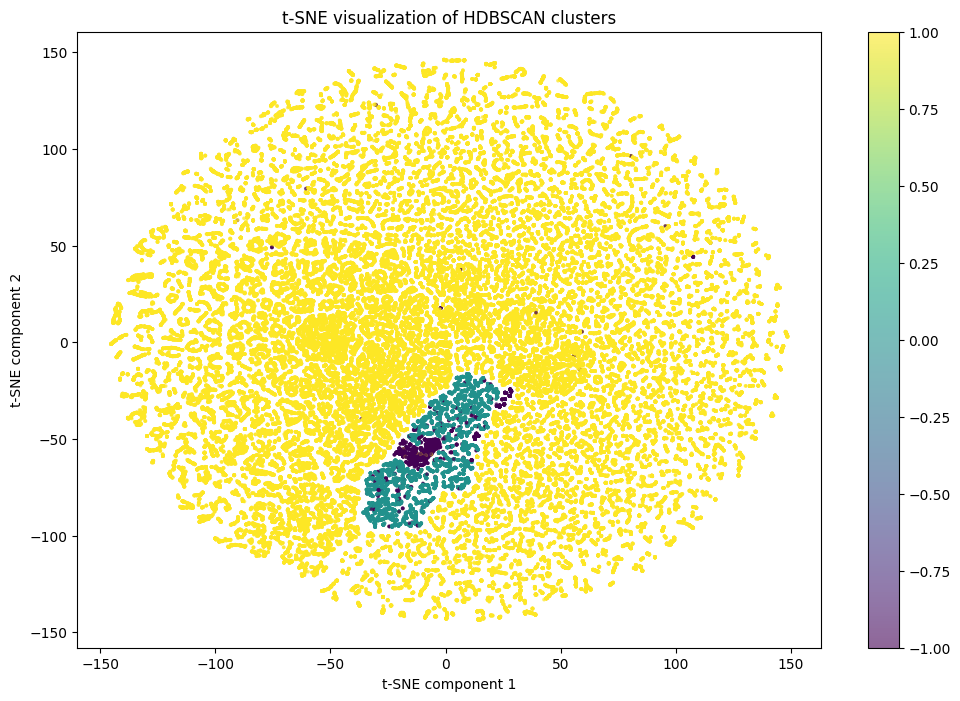

In [106]:
# Create scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=X_train['cluster'], alpha=0.6, s=3)
plt.colorbar()
plt.title('t-SNE visualization of HDBSCAN clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()